In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.preprocessing import scale
from statsmodels.base.model import GenericLikelihoodModel
%matplotlib inline

In [2]:
pklfile = '../learn/pkl_trainsets/19aug2019_opusupdate/mlecompare_not-scaled_15nuc.pkl'
XY = pd.read_pickle(pklfile)
XY.reset_index(inplace=True, drop=True)
if 'total' in XY.columns:
    XY.drop('total', axis=1, inplace=True)
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']

### Replace nuclide concentrations with ratios

- cs137/cs133
- cs134/cs137
- cs135/cs137
- ba136/ba138
- sm150/sm149
- sm152/sm149
- eu154/eu153
- pu240/pu239
- pu241/pu239
- pu242/pu239

In [17]:
ratios = XY.loc[:, lbls].copy()

In [18]:
#cs137/cs133
ratios['cs137/cs133'] = XY['cs137'] / XY['cs133']
#cs134/cs137
ratios['cs134/cs137'] = XY['cs134'] / XY['cs137']
#cs135/cs137
ratios['cs135/cs137'] = XY['cs135'] / XY['cs137']
#ba136/ba138
ratios['ba136/ba138'] = XY['ba136'] / XY['ba138']
#sm150/sm149
ratios['sm150/sm149'] = XY['sm150'] / XY['sm149']
#sm152/sm149
ratios['sm152/sm149'] = XY['sm152'] / XY['sm149']
#eu154/eu153
ratios['eu154/eu153'] = XY['eu154'] / XY['eu153']
#pu240/pu239
ratios['pu240/pu239'] = XY['pu240'] / XY['pu239']
#pu241/pu239
ratios['pu241/pu239'] = XY['pu241'] / XY['pu239']
#pu242/pu239
ratios['pu242/pu239'] = XY['pu242'] / XY['pu239']

ratios.replace([np.inf, -np.inf], 0, inplace=True)
ratios.fillna(0, inplace = True)
#ratios

In [79]:
### filter trainXY ###
#Need to explicitly tell pandas not to worry that I'm making a copy
trainXY = ratios.loc[ratios['Burnup'] > 0].copy()
trainXY = trainXY.sample(frac=0.15)
trainXY.shape

(10972, 15)

In [80]:
test_lbls = ['sm152/sm149'] + lbls
testXY = trainXY[test_lbls].copy()

In [81]:
def splitXY(dfXY):
    lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
    dfX = dfXY.drop(lbls, axis=1)
    r_dfY = dfXY.loc[:, lbls[0]]
    c_dfY = dfXY.loc[:, lbls[1]]
    e_dfY = dfXY.loc[:, lbls[2]]
    b_dfY = dfXY.loc[:, lbls[3]]
    o_dfY = dfXY.loc[:, lbls[4]]
    return dfX, r_dfY, c_dfY, e_dfY, b_dfY, o_dfY

X, rY, cY, eY, bY, oY = splitXY(testXY)

In [82]:
testXY.shape

(10972, 6)

In [97]:
sim_idx = 44360

In [98]:
test_sample = testXY.loc[testXY.index == sim_idx].drop(lbls, axis=1)
test_answer = testXY.loc[testXY.index == sim_idx, lbls]
test_answer
#test_sample

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
44360,agr,2533.773242,3.63,2602.55,agr


In [99]:
def ll_calc(y_sim, y_mes, std):
    ll = np.sum(stats.norm.logpdf(y_sim, loc=y_mes, scale=std))
    return ll

def unc_calc(y_sim, y_mes, sim_unc_sq, mes_unc_sq):
    unc = ((y_sim - y_mes) / sim_unc_sq)**2 * (sim_unc_sq + mes_unc_sq)
    unc.replace([np.inf, -np.inf], 0, inplace=True)
    unc.fillna(0, inplace = True)
    return np.sqrt(unc.sum(axis=1))

In [100]:
uncs = [0.07, 0.14, 0.28]
for unc in uncs:
    ll_name = 'LogLikelihood_' + str(unc)
    unc_name = 'LLUncertainty_' + str(unc)
    testXY[ll_name] = X.apply(lambda row: ll_calc(row, test_sample.iloc[0], unc*row), axis=1)
    testXY[unc_name] = X.apply(lambda row: unc_calc(row, test_sample.iloc[0], (unc*row)**2, (unc*test_sample)**2), axis=1)

In [101]:
testXY.sample(5)

,sm152/sm149,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,LogLikelihood_0.07,LLUncertainty_0.07,LogLikelihood_0.14,LLUncertainty_0.14,LogLikelihood_0.28,LLUncertainty_0.28
58265,18.128031,phwr,1384.210063,0.711,6624.81,candu19,-54.188386,10.692242,-15.108097,5.346121,-5.857885,2.673061
23524,9.800443,pwr,5019.607408,2.990,6762.83,vver1000,-24.421736,7.777368,-7.205161,3.888684,-3.420877,1.944342
38920,11.899083,agr,3206.767868,3.090,5188.78,agr,-34.450658,8.922977,-9.857917,4.461488,-4.229592,2.230744
66002,8.426716,phwr,3433.701885,0.711,3608.70,candu37,-16.684838,6.658432,-5.157671,3.329216,-2.795740,1.664608
56593,12.328767,phwr,5103.806552,0.711,4988.73,candu19,-36.246911,9.104900,-10.333585,4.552450,-4.375114,2.276225


In [104]:
x = testXY['Burnup']
y1 = testXY['LogLikelihood_0.07']
y2 = testXY['LogLikelihood_0.14']
y3 = testXY['LogLikelihood_0.28']

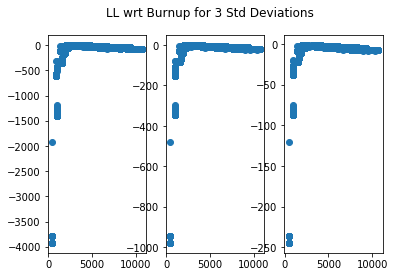

In [108]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('LL wrt Burnup for 3 Std Deviations')
ax.set_xlabel('Burnup [MWd/MTHM]')
ax1.scatter(x, y1)
ax2.scatter(x, y2)
ax3.scatter(x, y3)
plt.show()

# ML Estimation
## Coefficients of linear models estimated
This example is done with dependent variable = burnup

In [21]:
class NormMod(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(NormMod, self).__init__(endog, exog, **kwds)
    
    def nloglikeobs(self, params):
        beta = params
        yhat = np.dot(self.exog, beta)
        LL = stats.norm.logpdf(self.endog, loc=yhat)
        return -LL
    
    def fit(self, start_params=None, maxiter=100000, maxfun=100000, **kwds):
        if start_params == None:
            start_params = np.zeros(self.exog.shape[1])
            start_params[0] = np.log(self.endog.mean())
        return super(NormMod, self).fit(start_params=start_params,
                                        maxiter=maxiter, maxfun=maxfun,
                                        **kwds)
    
    def predict(self, nuc_list):
        
        return burn

In [22]:
y = bY
X = sm.add_constant(X)

/home/opotowsky/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [23]:
X.shape

(14629, 11)

In [24]:
X

,const,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,sm150/sm149,sm152/sm149,eu154/eu153,pu240/pu239,pu241/pu239,pu242/pu239
53806,1.0,0.823392,0.000721,0.342803,0.001343,10.968661,5.628680,0.020296,0.040731,0.001372,3.431042e-05
28420,1.0,0.749728,0.000705,0.335512,0.002772,10.612981,5.221154,0.027415,0.080265,0.010929,5.689857e-04
61655,1.0,0.913999,0.013757,0.284238,0.003233,54.132357,32.032124,0.088586,0.195413,0.033621,3.776233e-03
54166,1.0,0.898284,0.002690,0.313029,0.001412,11.777379,6.193896,0.030624,0.046300,0.002115,5.029059e-05
729,1.0,0.806251,0.000714,0.297304,0.001567,4.238126,1.985237,0.017304,0.036391,0.002463,4.720175e-05
27384,1.0,0.761687,0.000536,0.327977,0.002041,5.970571,2.839640,0.019812,0.050784,0.004537,1.376314e-04
62475,1.0,0.749282,0.000023,0.401342,0.000911,1.344025,0.713399,0.002719,0.006795,0.000037,1.943396e-07
686,1.0,0.828607,0.001036,0.289283,0.001567,4.238126,1.985237,0.019040,0.036408,0.002608,4.718886e-05
66783,1.0,0.847470,0.002108,0.328358,0.001862,19.971751,11.026365,0.036554,0.084623,0.006106,2.880040e-04
53676,1.0,0.892788,0.002162,0.316157,0.001343,10.968661,5.628680,0.026941,0.040748,0.001627,3.431042e-05


In [25]:
mod = NormMod(y, X)

In [26]:
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 545458.327359
         Iterations: 1704
         Function evaluations: 2503
                               NormMod Results                                
Dep. Variable:                 Burnup   Log-Likelihood:            -7.9795e+09
Model:                        NormMod   AIC:                         1.596e+10
Method:            Maximum Likelihood   BIC:                         1.596e+10
Date:                Mon, 26 Aug 2019                                         
Time:                        12:39:45                                         
No. Observations:               14629                                         
Df Residuals:                   14618                                         
Df Model:                          10                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

/home/opotowsky/.local/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/opotowsky/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/opotowsky/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/opotowsky/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [27]:
res.params

array([ 152.78657995,  573.3246519 ,    9.28999576,  296.89667871,
       -466.11324286,  578.71779207, -664.32524069, -397.83215989,
        170.26901221, -109.53584399, -515.51328671])

In [28]:
test_sample.insert(0, 'const', 1.0)

In [29]:
burn_pred = np.sum(test_sample.iloc[0] * res.params)
burn_pred, test_answer['Burnup']

(2692.582140167781, 43552    1604.81
 Name: Burnup, dtype: float64)